In [1]:
import torch
import json

import pandas as pd
import matplotlib.pyplot as plt

from transformers import OPTForCausalLM, AutoTokenizer
from datasets import load_dataset, Dataset

from data_utils import (
    load_glue_datasets,
    load_hans_dataset,
    load_mnli_mismatched_dataset,
    load_paws_qqp_dataset,
    load_cola_ood_dataset,
    task_to_keys
)
from context_utils import create_few_shot_context

In [2]:
# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Tokenizer + Models

In [4]:
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-125m") # tokenizer
teacher_model = OPTForCausalLM.from_pretrained("facebook/opt-125m") # teacher model
student_model = OPTForCausalLM.from_pretrained("facebook/opt-125m") # student model

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

## Datasets

In [5]:
data_set_used='mnli'
datasets, labels, num_labels = load_glue_datasets(data_set_used)

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

Filter:   0%|          | 0/392702 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9815 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9832 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9796 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9847 [00:00<?, ? examples/s]

Map:   0%|          | 0/261802 [00:00<?, ? examples/s]

Map:   0%|          | 0/6692 [00:00<?, ? examples/s]

Map:   0%|          | 0/6703 [00:00<?, ? examples/s]

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/261802 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/6692 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/6703 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9796 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9847 [00:00<?, ? examples/s]

In [8]:
def create_batch_token(dataset_name, datasets,tokenizer,num_shots=1, device = 'cpu', split='train',len_subset=300):
    batch_tokens = []
    batch_strings = []
    datasets = datasets[split]
    for i in range(0, len_subset, num_shots):
        if split == 'train':
            context, student_context, indices = create_few_shot_context(
                dataset_name,
                datasets,
                num_shots,
                teacher_description=""
                from_indices=list(range(i, i + num_shots))
            )
            token_data= {
                'context':(tokenizer(context, return_tensors="pt")).to(device),
                'query':(tokenizer(student_context, return_tensors="pt")).to(device)
            }
            string_data = {
                'context':context,
                'query':student_context
            }
        else:
            context, student_context, indices = create_few_shot_context(
                dataset_name,
                datasets,
                num_shots,
                from_indices=list(range(i, i + num_shots))
            )
            token_data = (tokenizer(student_context, return_tensors="pt")).to(device)
            string_data = student_context
        batch_tokens.append(token_data)
        batch_strings.append(string_data)
    return batch_tokens, batch_strings

train_data_tokens, train_data_strings = create_batch_token(
    data_set_used, datasets, num_shots=3, tokenizer=tokenizer, device=device
)
student_prompt_tokens, student_prompt_strings = create_batch_token(
    data_set_used, datasets, num_shots=1, tokenizer=tokenizer, device=device,split= 'validation_matched'
)


In [9]:
train_data_strings

[{'context': 'Premise: you know during the season and i guess at at your level uh you lose them to the next level if if they decide to recall the the parent team the Braves decide to call to recall a guy from triple A then a double A guy goes up to replace him and a single A guy goes up to replace him,\nHypothesis: You lose the things to the following level if the people recall.,\nLabel: entailment\n\nPremise: One of our number will carry out your instructions minutely.,\nHypothesis: A member of my team will execute your orders with immense precision.,\nLabel: entailment\n\nPremise: How do you know? All this is their information again.,\nHypothesis: This information belongs to them.,\nLabel: \n\n',
  'query': 'Label if this is entailment or contradiction.\nPremise: How do you know? All this is their information again.,\nHypothesis: This information belongs to them.,\nLabel: \n\n'},
 {'context': "Premise: my walkman broke so i'm upset now i just have to turn the stereo up real loud,\nHy

In [10]:
# Assuming `losses` is the list of epoch losses returned from the `train` function
def plot_losses(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, marker='o', linestyle='-', color='b')
    plt.title('Training Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()

Epoch 1, Total Loss: 0.9191097258590162
Epoch 2, Total Loss: 0.46913294758026797
Total loss : 1.407398842740804


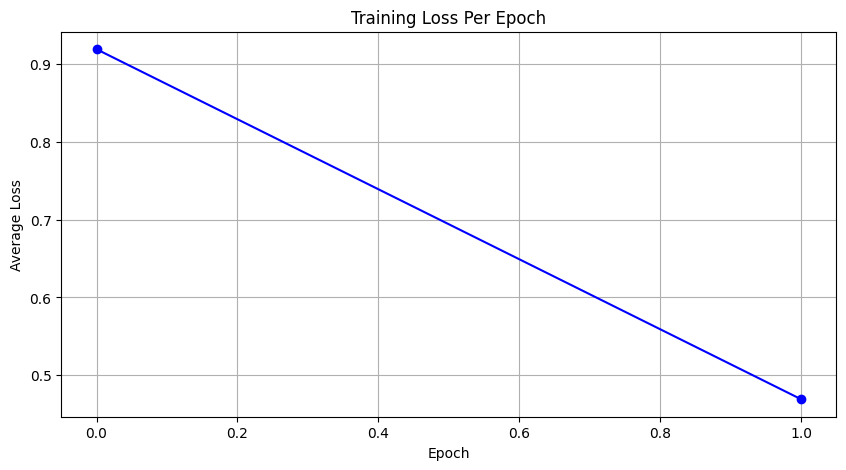

In [11]:
def train(data, epochs=2, batch_size=16, device='cpu'):
    student_model.to(device)
    teacher_model.to(device)
    
    student_model.train()
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=0.001)
    epoch_losses = []


    for epoch in range(epochs):
        total_loss = 0
        num_batches = len(data) // batch_size 
        
        for i in range(num_batches):
            batch_loss = 0
            for j in range(batch_size):
                index = i * batch_size + j
                
                teacher_inputs = data[index]['context'].to(device)
                student_inputs = data[index]['query'].to(device)
                                
                teacher_outputs = teacher_model.generate(**teacher_inputs, max_length=teacher_inputs['input_ids'].shape[-1] + 1, output_scores=True, return_dict_in_generate=True)
                teacher_probs = torch.nn.functional.softmax(teacher_outputs.scores[0], dim=-1)
                
                student_logits = student_model(**student_inputs).logits
                student_probs = torch.nn.functional.softmax(student_logits[:, -1, :], dim=-1)
                
                kl_divergence = torch.nn.functional.kl_div(student_probs.log(), teacher_probs, reduction='batchmean')
                
                optimizer.zero_grad()
                kl_divergence.backward()
                optimizer.step()

                batch_loss += kl_divergence.item()

            # Average loss for the batch
            batch_loss /= batch_size
            total_loss += batch_loss
            # print(f"Epoch {epoch + 1}, Batch {i + 1}, Average Loss: {batch_loss}")


        # Average loss for the epoch
        epoch_loss = total_loss / num_batches
        epoch_losses.append(epoch_loss)

        print(f"Epoch {epoch + 1}, Total Loss: {epoch_loss}")
        
    print(f"Total loss : {total_loss/epochs}")
    plot_losses(epoch_losses)
    # torch.save(student_model, './models/student.pth')


train(train_data, device=device)


In [9]:
def predict(model, source, target=None, device='cpu'):
    predict = []
    for token in source:
        output = model.generate(**token, max_length=token['input_ids'].shape[-1] + 1).to(device)
        decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
        predicted_label = decoded_output.split("Label:")[-1].strip().split('.')[0].strip()
        predict.append(predicted_label)
        
    return predict

student_prompt_token = create_batch_token(data_set_used, datasets,num_shots=1,tokenizer=tokenizer, device=device,split= 'validation_matched')
predict = predict(student_model, student_prompt_token, device=device)  


In [10]:
predict

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Prem',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Hyp',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 ''